In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
import torchvision.utils as vutils
import os

# Set random seed for reproducibility
manualSeed = 6789
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# Generator shared layers
class GeneratorSharedLayers(nn.Module):
    def __init__(self, ngf, nc):
        super(GeneratorSharedLayers, self).__init__()
        self.main = nn.Sequential(
            # First upsampling
            nn.ConvTranspose1d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.ReLU(True),
            # Second upsampling
            nn.ConvTranspose1d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.ReLU(True),
            # Third upsampling
            nn.ConvTranspose1d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.ReLU(True),
            # Output layer
            nn.ConvTranspose1d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Generator with unique input layer and shared layers
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, shared_layers):
        super(Generator, self).__init__()
        self.ngf = ngf  # Store ngf as an instance variable
        self.input_layer = nn.Sequential(
            nn.Linear(nz, ngf * 8 * 4 * 4),
            nn.BatchNorm1d(ngf * 8 * 4 * 4),
            nn.ReLU(True)
        )
        self.shared_layers = shared_layers

    def forward(self, input):
        x = self.input_layer(input)
        x = x.view(-1, self.ngf * 8, 4, 4)  # Use self.ngf here
        x = self.shared_layers(x)
        return x

# Discriminator and Classifier shared layers
class DiscriminatorSharedLayers(nn.Module):
    def __init__(self, ndf, nc):
        super(DiscriminatorSharedLayers, self).__init__()
        self.main = nn.Sequential(
            # Input layer
            nn.Conv1d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # Hidden layer
            nn.Conv1d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Hidden layer
            nn.Conv1d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Hidden layer
            nn.Conv1d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, input):
        return self.main(input)

# Discriminator with shared layers and unique output layers
class Discriminator(nn.Module):
    def __init__(self, ndf, nc, shared_layers, num_gens):
        super(Discriminator, self).__init__()
        self.ndf = ndf  # Store ndf as an instance variable
        self.shared_layers = shared_layers
        self.output_bin = nn.Sequential(
            nn.Conv1d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.output_mul = nn.Sequential(
            nn.Conv2d(ndf * 8, num_gens, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        x = self.shared_layers(input)
        output_bin = self.output_bin(x).view(-1, 1).squeeze(1)
        output_mul = self.output_mul(x).squeeze()
        return output_bin, output_mul

# MGAN class encapsulating the training loop
class MGAN:
    def __init__(self,
                 num_z=100,
                 beta=0.5,
                 num_gens=4,
                 batch_size=128,
                 z_prior="gaussian",
                 learning_rate=0.0002,
                 num_epochs=50,
                 img_size=(64, 64, 1),
                 num_gen_feature_maps=64,
                 num_dis_feature_maps=64,
                 sample_dir="samples",
                 device='cpu'):
        self.beta = beta
        self.num_z = num_z
        self.num_gens = num_gens
        self.batch_size = batch_size
        self.z_prior = z_prior
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.img_size = img_size
        self.ngf = num_gen_feature_maps
        self.ndf = num_dis_feature_maps
        self.sample_dir = sample_dir
        self.device = device
        mel_bins, num_frames, num_channels = img_size

        self.history = {'d_loss': [], 'g_loss': []}

        self._build_model()

    def _build_model(self):
        # Shared layers for Generators
        self.shared_gen_layers = GeneratorSharedLayers(self.ngf, self.img_size[2]).to(self.device)
        # List of Generators
        self.generators = nn.ModuleList([
            Generator(self.num_z, self.ngf, self.img_size[2], self.shared_gen_layers).to(self.device)
            for _ in range(self.num_gens)
        ])

        # Shared layers for Discriminator
        self.shared_dis_layers = DiscriminatorSharedLayers(self.ndf, self.img_size[2]).to(self.device)
        # Discriminator
        self.discriminator = Discriminator(self.ndf, self.img_size[2], self.shared_dis_layers, self.num_gens).to(self.device)

        # Optimizers
        # Combine parameters for shared layers and unique layers
        self.optimizerD = optim.Adam(
            list(self.discriminator.parameters()) + list(self.shared_dis_layers.parameters()),
            lr=self.learning_rate, betas=(0.5, 0.999)
        )
        all_params = list(self.discriminator.parameters()) + list(self.shared_dis_layers.parameters())
        print(f"Unique Parameters: {len(set(id(p) for p in all_params))}")
        print(f"Total Parameters: {len(all_params)}")


        # Generators have unique input layers but shared layers
        gen_params = []
        for gen in self.generators:
            gen_params += list(gen.input_layer.parameters())
        # Add shared generator layers
        gen_params += list(self.shared_gen_layers.parameters())
        self.optimizerG = optim.Adam(gen_params, lr=self.learning_rate, betas=(0.5, 0.999))

        # Loss functions
        self.criterion_bin = nn.BCELoss()
        self.criterion_mul = nn.CrossEntropyLoss()

    def fit(self, trainloader):
        fixed_noise = self._sample_z(self.num_gens * 16).to(self.device)

        real_label = 1.0  # Ensure this is a float
        fake_label = 0.0  # Ensure this is a float

        for epoch in range(self.num_epochs):
            for i, data in enumerate(trainloader, 0):
                ############################
                # (1) Update D network
                ###########################
                self.discriminator.zero_grad()
                real_images = data[0].to(self.device)
                b_size = real_images.size(0)
                label = torch.full((b_size,), real_label, device=self.device, dtype=torch.float)

                # Forward pass real batch through D
                output_bin_real, _ = self.discriminator(real_images)
                d_bin_real_loss = self.criterion_bin(output_bin_real, label)

                # Generate fake images
                fake_images = []
                gen_labels = []
                for idx, gen in enumerate(self.generators):
                    z = self._sample_z(b_size // self.num_gens).to(self.device)
                    gen_imgs = gen(z)
                    fake_images.append(gen_imgs)
                    gen_labels.append(torch.full((gen_imgs.size(0),), idx, dtype=torch.long, device=self.device))

                fake_images = torch.cat(fake_images, 0)
                gen_labels = torch.cat(gen_labels, 0)

                label_fake = torch.full((fake_images.size(0),), fake_label, device=self.device, dtype=torch.float)

                # Forward pass fake batch through D
                output_bin_fake, output_mul_fake = self.discriminator(fake_images.detach())
                d_bin_fake_loss = self.criterion_bin(output_bin_fake, label_fake)
                d_mul_loss = self.criterion_mul(output_mul_fake, gen_labels)

                # Sum all discriminator losses
                d_loss = d_bin_real_loss + d_bin_fake_loss + d_mul_loss * self.beta
                d_loss.backward()
                self.optimizerD.step()

                ############################
                # (2) Update G network
                ###########################
                for gen in self.generators:
                    gen.zero_grad()
                self.shared_gen_layers.zero_grad()

                # We want the generator to fool the discriminator
                label = torch.full((fake_images.size(0),), real_label, device=self.device, dtype=torch.float)

                output_bin_fake, output_mul_fake = self.discriminator(fake_images)
                g_bin_loss = self.criterion_bin(output_bin_fake, label)
                g_mul_loss = self.criterion_mul(output_mul_fake, gen_labels) * self.beta

                g_loss = g_bin_loss + g_mul_loss
                g_loss.backward()
                self.optimizerG.step()

                # Save losses for plotting
                self.history['d_loss'].append(d_loss.item())
                self.history['g_loss'].append(g_loss.item())

            # Output training stats
            print('[%d/%d] d_loss: %.4f | g_loss: %.4f'
                  % (epoch+1, self.num_epochs,
                     d_loss.item(),
                     g_loss.item()))

            # Save samples every few epochs
            if (epoch+1) % 5 == 0:
                self._save_samples(epoch+1, fixed_noise)

        # After training, plot the learning curves
        self._plot_history()

    def _sample_z(self, size):
        if self.z_prior == "uniform":
            return torch.rand(size, self.num_z) * 2 - 1  # Uniform between [-1, 1]
        else:
            return torch.randn(size, self.num_z)

    def _save_samples(self, epoch, fixed_noise):
        # Create directory if it doesn't exist
        if not os.path.exists(self.sample_dir):
            os.makedirs(self.sample_dir)

        # Generate images
        with torch.no_grad():
            fake_images_list = []
            for idx, gen in enumerate(self.generators):
                noise = fixed_noise[idx * 16: (idx + 1) * 16]
                gen.eval()
                fake_images = gen(noise.to(self.device))
                gen.train()
                fake_images_list.append(fake_images)

            # Concatenate images from all generators
            fake_images = torch.cat(fake_images_list, 0)

            # Normalize images to range [0, 1]
            fake_images = (fake_images + 1) / 2.0

            # Save the images
            sample_path = os.path.join(self.sample_dir, 'epoch_{:04d}.png'.format(epoch))
            vutils.save_image(fake_images, sample_path, nrow=16, padding=2, normalize=True)

    def _plot_history(self):
        # Plot the learning curves
        plt.figure(figsize=(10,5))
        plt.title("Loss During Training")
        plt.plot(self.history['d_loss'], label="D Loss")
        plt.plot(self.history['g_loss'], label="G Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()



In [2]:
def fit(self, dataloader):
    fixed_noise = self._sample_z(self.num_gens * 16).to(self.device)
    real_label = 1.0
    fake_label = 0.0

    for epoch in range(self.num_epochs):
        for i, (real_images,) in enumerate(dataloader):
            self.discriminator.zero_grad()
            real_images = real_images.to(self.device)
            b_size = real_images.size(0)
            label = torch.full((b_size,), real_label, device=self.device, dtype=torch.float)

            # Forward pass real batch through D
            output_bin_real, _ = self.discriminator(real_images)
            d_bin_real_loss = self.criterion_bin(output_bin_real, label)

            # Generate fake images
            fake_images = []
            gen_labels = []
            for idx, gen in enumerate(self.generators):
                z = self._sample_z(b_size // self.num_gens).to(self.device)
                gen_imgs = gen(z)
                fake_images.append(gen_imgs)
                gen_labels.append(torch.full((gen_imgs.size(0),), idx, dtype=torch.long, device=self.device))

            fake_images = torch.cat(fake_images, 0)
            gen_labels = torch.cat(gen_labels, 0)

            output_bin_fake, output_mul_fake = self.discriminator(fake_images.detach())
            d_bin_fake_loss = self.criterion_bin(output_bin_fake, torch.full((fake_images.size(0),), fake_label, device=self.device, dtype=torch.float))
            d_mul_loss = self.criterion_mul(output_mul_fake, gen_labels)

            d_loss = d_bin_real_loss + d_bin_fake_loss + d_mul_loss * self.beta
            d_loss.backward()
            self.optimizerD.step()

        print(f"Epoch [{epoch+1}/{self.num_epochs}] D Loss: {d_loss.item()}")

    print("Training complete!")


In [3]:
import os
import librosa
import torch
import numpy as np
from glob import glob
from torch.utils.data import DataLoader, TensorDataset

In [4]:
#Loading dataset
def load_flac(file_path, target_sr=16000):
    """Load a FLAC audio file and resample it to the target sample rate."""
    audio, sr = librosa.load(file_path, sr=target_sr)  # Waveform convertig
    audio = audio / np.max(np.abs(audio))  # Normalize to [-1, 1]
    return audio

def load_librispeech_data(root_dir, target_sr=16000):
    """Load all FLAC files from the LibriSpeech dataset."""
    flac_files = glob(os.path.join(root_dir, '**', '*.flac'), recursive=True)
    dataset = []

    for file in flac_files:
        audio = load_flac(file, target_sr)
        dataset.append(audio)

    return dataset

#preprocess

def pad_or_trim(audio, target_length=32000): #GAN need to fix lenght
    """Pad or trim audio to the target length."""
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    else:
        audio = audio[:target_length]
    return audio

def preprocess_dataset(root_dir, target_sr=16000, target_length=32000):
    """Load and preprocess all audio files in the dataset."""
    flac_files = glob(os.path.join(root_dir, '**', '*.flac'), recursive=True)
    dataset = []

    for file in flac_files:
        audio = load_flac(file)
        audio = pad_or_trim(audio, target_length)
        
        # # Optional: Split into frequency bands or segments if needed
        # low_band, high_band = split_into_bands(audio)
        # dataset.append((low_band, high_band))  # For multiple generators

        dataset.append(audio)  # For single generator or raw audio input
    dataset = torch.tensor(dataset, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    return TensorDataset(dataset)

In [5]:
def librispeech_to_mel(root_dir, target_sr=16000, n_mels=64, n_fft=1024, hop_length=512, target_length=128):
    """
    Convert raw LibriSpeech audio files to Mel spectrograms and return a TensorDataset.
    """
    from glob import glob

    flac_files = glob(os.path.join(root_dir, '**', '*.flac'), recursive=True)
    mel_spectrograms = []  # Initialize list to store Mel spectrograms

    if len(flac_files) == 0:
        raise ValueError(f"No FLAC files found in directory: {root_dir}")

    for file in flac_files:
        try:
            # Load the audio file
            audio, sr = librosa.load(file, sr=target_sr)
            # Normalize audio to range [-1, 1]
            audio = audio / np.max(np.abs(audio))
            
            # Convert to Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            
            # Convert to dB scale
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # Ensure the Mel spectrogram has a fixed length
            if mel_spec_db.shape[1] < target_length:
                # Pad if shorter
                pad_width = target_length - mel_spec_db.shape[1]
                mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
            else:
                # Trim if longer
                mel_spec_db = mel_spec_db[:, :target_length]

            # Add channel dimension and append to list
            mel_tensor = torch.tensor(mel_spec_db, dtype=torch.float32).unsqueeze(0)  # Add channel dim
            mel_spectrograms.append(mel_tensor)
        
        except Exception as e:
            print(f"Error processing file {file}: {e}")

    if len(mel_spectrograms) == 0:
        raise ValueError("No valid audio files were processed into Mel spectrograms.")

    # Stack into a single tensor
    mel_spectrograms = torch.stack(mel_spectrograms)  # Shape: [num_samples, 1, n_mels, target_length]
    return TensorDataset(mel_spectrograms)


In [6]:
data_dir = r'data\LibriSpeech\LibriSpeech\dev-clean'

# Preprocess the dataset and convert to Mel spectrograms
mel_dataset = librispeech_to_mel(data_dir)

# Create a DataLoader
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(mel_dataset, batch_size=batch_size, shuffle=True)

# Check the shape of a batch
for mel_spectrograms in dataloader:
    print(f"Batch shape: {mel_spectrograms[0].shape}")  # Should be [batch_size, 1, n_mels, target_length]
    break

Batch shape: torch.Size([32, 1, 64, 128])


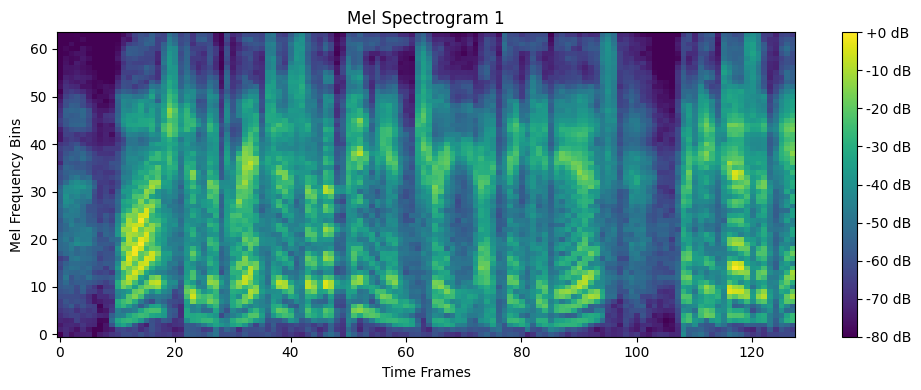

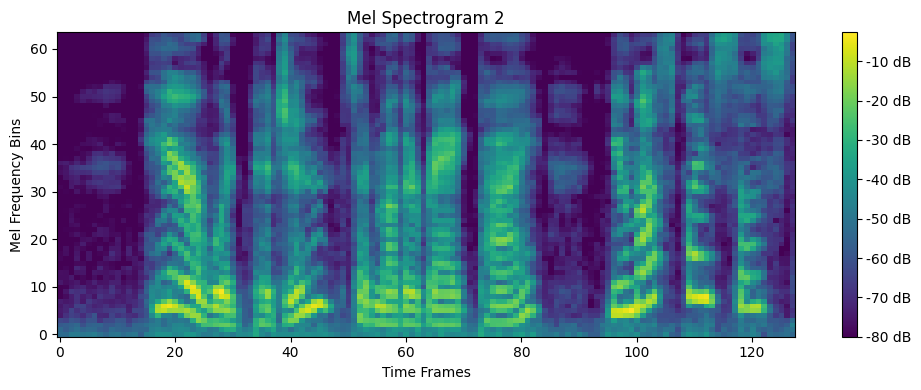

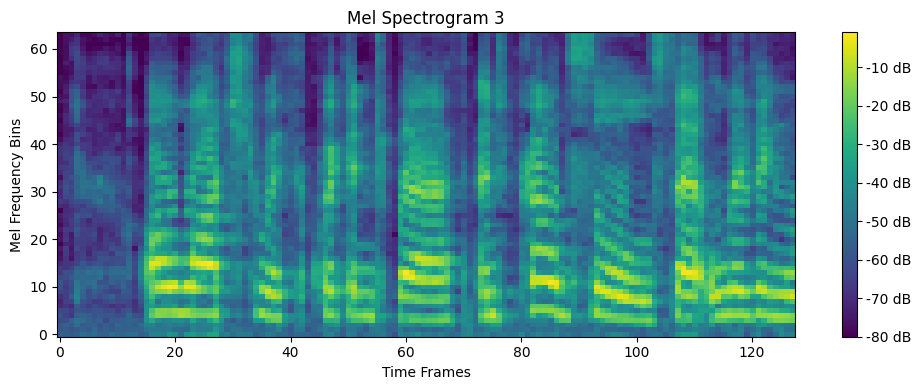

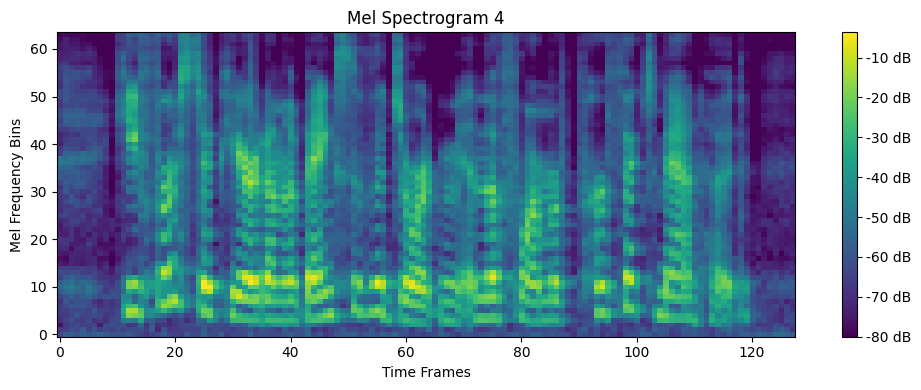

In [7]:
import matplotlib.pyplot as plt

def visualize_mel_spectrogram(mel_spec, sr=16000, hop_length=512, title="Mel Spectrogram"):
    """
    Visualize a single Mel spectrogram.

    Parameters:
    - mel_spec (torch.Tensor or np.ndarray): The Mel spectrogram to visualize.
    - sr (int): Sample rate of the audio (default: 16000).
    - hop_length (int): Hop length used to calculate the spectrogram (default: 512).
    - title (str): Title of the plot.
    """
    if isinstance(mel_spec, torch.Tensor):
        mel_spec = mel_spec.squeeze().cpu().numpy()  # Convert to NumPy if it's a tensor

    plt.figure(figsize=(10, 4))
    # Display the Mel spectrogram as an image
    plt.imshow(mel_spec, aspect="auto", origin="lower", cmap="viridis")
    plt.title(title)
    plt.ylabel("Mel Frequency Bins")
    plt.xlabel("Time Frames")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()
# Assume `dataloader` is already defined
for mel_spectrograms in dataloader:
    batch = mel_spectrograms[0]  # Shape: [batch_size, 1, n_mels, target_length]
    for i in range(min(4, len(batch))):  # Visualize up to 4 spectrograms
        mel_spec = batch[i]
        visualize_mel_spectrogram(mel_spec, title=f"Mel Spectrogram {i + 1}")
    break



In [ ]:
# Main function to train MGAN
def main():
    # Hyperparameters
    num_z = 100
    beta = 0.5
    num_gens = 4
    batch_size = 32
    z_prior = "gaussian"
    learning_rate = 0.0002
    num_epochs = 10
    num_gen_feature_maps = 64
    num_dis_feature_maps = 64
    audio_length = 32000  # Length of audio samples

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load and preprocess audio dataset
    data_dir = r'C:\Users\Admin\Documents\voice\voice\data\LibriSpeech\LibriSpeech\dev-clean'
    audio_dataset = preprocess_dataset(data_dir, target_length=audio_length)
    
    # Create DataLoader for the audio dataset
    dataloader = DataLoader(audio_dataset, batch_size=batch_size, shuffle=True)
    
    print(f"Loaded {len(audio_dataset)} audio files.")
    for i, (audio,) in enumerate(audio_dataset[:3]):
        print(f"Audio file {i+1}:")
        print(f"  - Type: {type(audio)}")
        print(f"  - Shape: {audio.shape}")
        print(f"  - First 10 samples: {audio[:10]}\n")
    
    # Create the MGAN model
    mgan_model = MGAN(
        num_z=num_z,
        beta=beta,
        num_gens=num_gens,
        batch_size=batch_size,
        z_prior=z_prior,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        num_gen_feature_maps=num_gen_feature_maps,
        num_dis_feature_maps=num_dis_feature_maps,
        sample_dir="samples",
        device=device
    )

    # Train the model using the DataLoader
    mgan_model.fit(dataloader)

# Execute the main function
if __name__ == '__main__':
    main()


Preprocessing dataset...
Dataset size: 0


ValueError: Dataset is empty. Check your data directory and preprocessing logic.